Tudo da vida segue uma distribuição gaussiana.
-V.C.A Marcelo

## Loading data

In [1]:
import pandas as pd
import numpy as np

df_gold = pd.read_csv('../data/d_kilo_gold_price_in_currency.csv')
df_gold['date'] = pd.to_datetime(df_gold['date'], infer_datetime_format=True)

data_x = np.array(df_gold['date'])
data_y = np.array(df_gold['America'])

data_table = pd.DataFrame()

## Forecasting with sktime

[source](https://www.sktime.org/en/latest/index.html)
[example1](https://towardsdatascience.com/sktime-a-unified-python-library-for-time-series-machine-learning-3c103c139a55)
[example2](https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb)

In [2]:
import numpy as np
from math import sqrt
from sktime.performance_metrics.forecasting import *
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.utils import check_array

import pandas as pd

def RMSE(y_test, y_pred):
    return MSE(y_test, y_pred, squared=False)

# https://github.com/alan-turing-institute/sktime/blob/master/sktime/performance_metrics/forecasting/_functions.py
def print_metrics(title, y_pred, y_test, y_train):
    print(f'metrics for [{title}]:')
    # https://otexts.com/fpp2/accuracy.html#scale-dependent-errors
    print('    MAE', MAE(y_pred, y_test))
    print('    RMSE', RMSE(y_pred, y_test))
    # https://otexts.com/fpp2/accuracy.html#percentage-errors
    print('    MAPE', mape_loss(y_pred, y_test))
    print('    sMAPE', smape_loss(y_pred, y_test))
    # https://otexts.com/fpp2/accuracy.html#scaled-errors
    print('    MASE', mase_loss(y_pred, y_test, y_train))
    
    d = {'Modelo':[title],
         'MAE':[MAE(y_pred, y_test)],
         'RMSE':[RMSE(y_pred, y_test)],
         'MAPE':[mape_loss(y_pred, y_test)],
         'SMAPE':[smape_loss(y_pred, y_test)],
         'MASE':[mase_loss(y_pred, y_test, y_train)]        
    }
    df = pd.DataFrame(data=d)                   
    
    return df

Importing plotly failed. Interactive plots will not work.


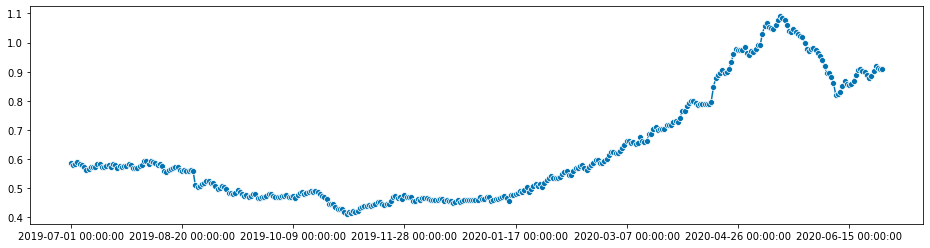

In [3]:
from sktime.forecasting.all import *
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.fbprophet import Prophet

# preparing data
y = pd.Series(data_y, index=data_x)
y.index.freq = 'd'
plot_series(y)

# defining the forecasting horizon
# days to predict = 1, 7, 30
days_to_predict = 1
y_train, y_test = temporal_train_test_split(y, test_size=days_to_predict)
fh = ForecastingHorizon(y_test.index, is_relative=False)
#fh = np.arange(len(y_test)) + days_to_predict


In [4]:
y_test.index

DatetimeIndex(['2020-06-30'], dtype='datetime64[ns]', freq='D')

In [5]:
y_train.index

DatetimeIndex(['2019-07-01', '2019-07-02', '2019-07-03', '2019-07-04',
               '2019-07-05', '2019-07-06', '2019-07-07', '2019-07-08',
               '2019-07-09', '2019-07-10',
               ...
               '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23',
               '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27',
               '2020-06-28', '2020-06-29'],
              dtype='datetime64[ns]', length=365, freq='D')

In [6]:
# naive forecaster (last)
# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.naive.NaiveForecaster.html
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred_naive_last = forecaster.predict(fh)
data_table = data_table.append(print_metrics('naive_last', y_pred_naive_last, y_test, y_train))

metrics for [naive_last]:
    MAE 0.0017447287813203705
    RMSE 0.0017447287813203705
    MAPE 0.0019198891435523186
    sMAPE 0.0019180479238594032
    MASE 0.2499419738768932


In [7]:
# naive forecaster (mean)
# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.naive.NaiveForecaster.html
forecaster = NaiveForecaster(strategy="mean")
forecaster.fit(y_train)
y_pred_naive_mean = forecaster.predict(fh)
data_table = data_table.append(print_metrics('naive_mean', y_pred_naive_mean, y_test, y_train))

metrics for [naive_mean]:
    MAE 0.28612442634354174
    RMSE 0.28612442634354174
    MAPE 0.45824950150284327
    sMAPE 0.37282586753109787
    MASE 40.988894469075035


In [8]:
# naive forecaster (drift)
# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.naive.NaiveForecaster.html
forecaster = NaiveForecaster(strategy="drift")
forecaster.fit(y_train)
y_pred_naive_drift = forecaster.predict(fh)
data_table = data_table.append(print_metrics('naive_drift', y_pred_naive_drift, y_test, y_train))

metrics for [naive_drift]:
    MAE 0.0008558924285653191
    RMSE 0.0008558924285653191
    MAPE 0.0009408986579852315
    sMAPE 0.0009404562209871212
    MASE 0.12261128796190968


In [9]:
# arima forecaster
# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.ARIMA.html
custom_method = { 1 : 'bfgs', 2 : 'bfgs', 7 : 'bfgs', 30 : 'powell' }
forecaster = ARIMA(method=custom_method[days_to_predict])
forecaster.fit(y_train)
y_pred_arima = forecaster.predict(fh)
data_table = data_table.append(print_metrics('arima', y_pred_arima, y_test, y_train))

C:\Users\RubensCividatiTeles\.conda\envs\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\RubensCividatiTeles\.conda\envs\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


metrics for [arima]:
    MAE 0.0018213607221923
    RMSE 0.0018213607221923
    MAPE 0.002004383494474495
    sMAPE 0.0020023767290417898
    MASE 0.2609199200015926


In [10]:
# auto arima forecaster
# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html
custom_method = { 1 : 'nm', 2 : 'nm', 7 : 'bfgs', 30 : 'cg' }
forecaster = AutoARIMA(method=custom_method[days_to_predict])
forecaster.fit(y_train)
y_pred_auto = forecaster.predict(fh)
data_table = data_table.append(print_metrics('auto', y_pred_auto, y_test, y_train))

C:\Users\RubensCividatiTeles\.conda\envs\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\RubensCividatiTeles\.conda\envs\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\RubensCividatiTeles\.conda\envs\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\RubensCividatiTeles\.conda\envs\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\RubensCividatiTeles\.conda\envs\py

metrics for [auto]:
    MAE 0.0018492541724881573
    RMSE 0.0018492541724881573
    MAPE 0.00203514234076796
    sMAPE 0.0020330735437425773
    MASE 0.26491580984981733


C:\Users\RubensCividatiTeles\.conda\envs\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\RubensCividatiTeles\.conda\envs\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [11]:
# exponential smoothing forecaster
# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.exp_smoothing.ExponentialSmoothing.html
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred_expo = forecaster.predict(fh)
data_table = data_table.append(print_metrics('expo', y_pred_expo, y_test, y_train))

metrics for [expo]:
    MAE 0.001744728731114753
    RMSE 0.001744728731114753
    MAPE 0.0019198890882002905
    sMAPE 0.001918047868613492
    MASE 0.24994196668466295


In [12]:
# theta forecaster
# https://www.sktime.org/en/v0.4.2/modules/auto_generated/sktime.forecasting.theta.ThetaForecaster.html
forecaster = ThetaForecaster()
forecaster.fit(y_train)
y_pred_theta = forecaster.predict(fh)
data_table = data_table.append(print_metrics('theta', y_pred_theta, y_test, y_train))

metrics for [theta]:
    MAE 0.00041374616346212534
    RMSE 0.00041374616346212534
    MAPE 0.0004546179743430178
    sMAPE 0.0004545146590762086
    MASE 0.059271408763862485


In [13]:
# polynomial trend forecaster
# https://www.sktime.org/en/v0.4.2/modules/auto_generated/sktime.forecasting.trend.PolynomialTrendForecaster.html
custom_degree = { 1 : 4, 2: 4, 7 : 4, 30 : 1 }
forecaster = PolynomialTrendForecaster(degree=custom_degree[days_to_predict])
forecaster.fit(y_train)
y_pred_poly = forecaster.predict(fh)
data_table = data_table.append(print_metrics('poly', y_pred_poly, y_test, y_train))

metrics for [poly]:
    MAE 0.03071206173588592
    RMSE 0.03071206173588592
    MAPE 0.03490808139899669
    sMAPE 0.03430924641568815
    MASE 4.399671406971996


In [14]:
# prophet forecaster
# https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.fbprophet.Prophet.html
# forecaster = Prophet()
forecaster = Prophet(yearly_seasonality=True, daily_seasonality=True)
forecaster.fit(y_train)
y_pred_prophet = forecaster.predict(fh)
data_table = data_table.append(print_metrics('prophet', y_pred_prophet, y_test, y_train))

metrics for [prophet]:
    MAE 0.006100114959729064
    RMSE 0.006100114959729064
    MAPE 0.00665508066761493
    sMAPE 0.006677299651526302
    MASE 0.8738749484930308


In [15]:
#!/usr/bin/env python3 -u
# -*- coding: utf-8 -*-
# copyright: sktime developers, BSD-3-Clause License (see LICENSE file)

__all__ = ["plot_series"]
__author__ = ["Markus Löning"]

import numpy as np

from sktime.utils.validation._dependencies import _check_soft_dependencies
from sktime.utils.validation.forecasting import check_y

def custom_plot_series(timespan, *series, labels=None):
    """Plot one or more time series

    Parameters
    ----------
    series : pd.Series
        One or more time series
    labels : list, optional (default=None)
        Names of series, will be displayed in figure legend

    Returns
    -------
    fig : plt.Figure
    ax : plt.Axis
    """
    _check_soft_dependencies("matplotlib", "seaborn")
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter, MaxNLocator
    from matplotlib.cbook import flatten
    import seaborn as sns

    for y in series:
        check_y(y)

    n_series = len(series)

    # labels
    if labels is not None:
        if n_series != len(labels):
            raise ValueError(
                """There must be one label for each time series,
                but found inconsistent numbers of series and
                labels."""
            )
        legend = True
    else:
        labels = ["" for _ in range(n_series)]
        legend = True

    # create combined index
    index = series[0].index
    for y in series[1:]:
        # check types, note that isinstance() does not work here because index
        # types inherit from each other, hence we check for type equality
        if not type(index) is type(y.index):  # noqa
            raise TypeError("Found series with different index types.")
        index = index.union(y.index)

    # generate integer x-values
    xs = [np.argwhere(index.isin(y.index)).ravel() for y in series]

    # create figure
    fig, ax = plt.subplots(1, figsize=plt.figaspect(0.5))
    colors = sns.color_palette("colorblind", n_colors=n_series)
    fig.set_size_inches(11.7, 8.27)
    fig.set_size_inches(11.7, 8.27)
  
    # plot series
    for x, y, color, label in zip(xs, series, colors, labels):
        sns.scatterplot(x=x, y=y, ax=ax, label=label, color=color)

    # combine data points for all series
    xs_flat = list(flatten(xs))

    # set x label of data point to the matching index
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in xs_flat:
            date_arr = str(index[int(tick_val)])[:10].split('-')
            date_str = f'{date_arr[2]}/{date_arr[1]}/{date_arr[0][:2]}'
            return date_str
        else:
            return ""

    # dynamically set x label ticks and spacing from index labels
    ax.xaxis.set_major_formatter(FuncFormatter(format_fn))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.grid()
    #ax = fig.add_axes([0.1,0.1,0.75,0.75]) # axis starts at 0.1, 0.1
    ax.legend(fontsize='xx-large')
    ax.set_xlabel('DATA', fontsize='xx-large')
    ax.set_ylabel('VALOR', fontsize='xx-large')
    plt.savefig(f'plot_{timespan}_days.png')
    print(fig)
    return fig, ax

### Gráfico completo - treino / teste / pred

Figure(842.4x595.44)


(<Figure size 842.4x595.44 with 1 Axes>,
 <AxesSubplot:xlabel='DATA', ylabel='VALOR'>)

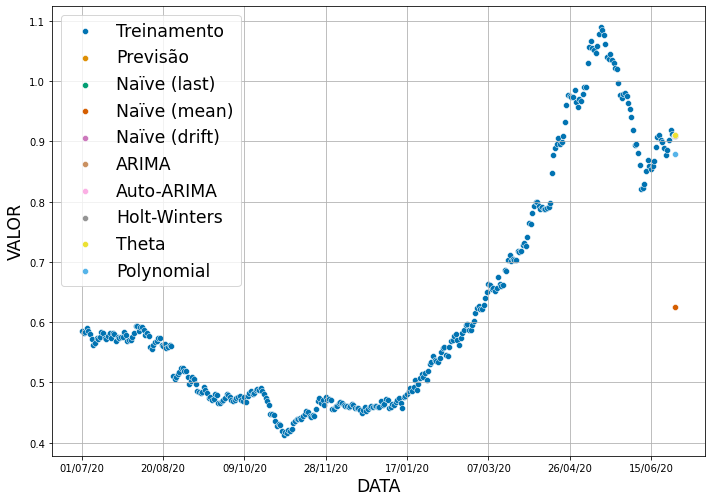

In [16]:
# plot all results
custom_plot_series(days_to_predict, y_train[:], y_test, y_pred_naive_last, y_pred_naive_mean, y_pred_naive_drift, y_pred_arima, y_pred_auto, y_pred_expo, y_pred_theta, y_pred_poly, 
            labels=["Treinamento", "Previsão", "Naïve (last)", "Naïve (mean)", "Naïve (drift)", "ARIMA", "Auto-ARIMA", "Holt-Winters", "Theta", "Polynomial"])

Figure(842.4x595.44)


(<Figure size 842.4x595.44 with 1 Axes>,
 <AxesSubplot:xlabel='DATA', ylabel='VALOR'>)

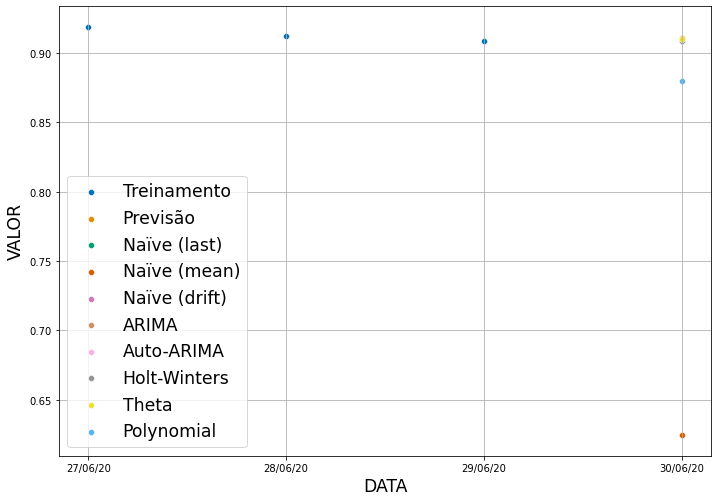

In [17]:
# plot all results
custom_plot_series(3*days_to_predict, y_train[-3*days_to_predict:], y_test, y_pred_naive_last, y_pred_naive_mean, y_pred_naive_drift, y_pred_arima, y_pred_auto, y_pred_expo, y_pred_theta, y_pred_poly, 
            labels=["Treinamento", "Previsão", "Naïve (last)", "Naïve (mean)", "Naïve (drift)", "ARIMA", "Auto-ARIMA", "Holt-Winters", "Theta", "Polynomial"])

In [32]:
print(f"""
y_test      {y_test[0]}
naive_last  {y_pred_naive_last[0]}
naive_mean  {y_pred_naive_mean[0]}
drift       {y_pred_naive_drift[0]}
arima       {y_pred_arima[0]}
auto        {y_pred_auto[0]}
expo        {y_pred_expo[0]}
thet        {y_pred_theta[0]}
poly        {y_pred_poly[0]}
""")


y_test      0.9105101057718618
naive_last  0.9087653769905414
naive_mean  0.62438567942832
drift       0.9096542133432964
arima       0.9086887450496695
auto        0.9086608515993736
expo        0.908765377040747
thet        0.9100963596083996
poly        0.8797980440359758



In [24]:
y_test[0]

0.9105101057718618

In [18]:
# metrics table
data_table

,Modelo,MAE,RMSE,MAPE,SMAPE,MASE
0,naive_last,0.001745,0.001745,0.001920,0.001918,0.249942
0,naive_mean,0.286124,0.286124,0.458250,0.372826,40.988894
0,naive_drift,0.000856,0.000856,0.000941,0.000940,0.122611
0,arima,0.001821,0.001821,0.002004,0.002002,0.260920
0,auto,0.001849,0.001849,0.002035,0.002033,0.264916
0,expo,0.001745,0.001745,0.001920,0.001918,0.249942
0,theta,0.000414,0.000414,0.000455,0.000455,0.059271
0,poly,0.030712,0.030712,0.034908,0.034309,4.399671
0,prophet,0.006100,0.006100,0.006655,0.006677,0.873875
